In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors 
# %matplotlib notebook

import ipysh

%aimport models.base

import Hunch_utils  as Htls
import Hunch_lsplot as Hplt
import Hunch_tSNEplot as Hsne

%aimport Dataset_QSH
%aimport models.AEFIT5
%aimport models.Compose
%aimport models.GAN3

import livelossplot.keras
class PlotLossesCallback(livelossplot.keras.PlotLossesCallback):
    def on_train_batch_begin(self, a, b): pass
    def on_train_batch_end(self, a, b): pass
    def on_test_begin(self, a): pass
    def on_test_end(self, a): pass
    def on_test_batch_begin(self, a, b): pass
    def on_test_batch_end(self, a, b): pass

    
class PlotRelevanceCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        fig.set_size_inches(13, 3)
        w = self.model.layers[1].weights
        ax1.bar(range(0,4), w[0][0:4])
        labels = ['Ip','NS','Vt','F']
        plt.sca(ax1)
        plt.xticks(range(0,4), labels, fontsize=10)
        ax2.bar(range(7,17), w[0][4:14])
        plt.sca(ax2)
        plt.xticks(range(7,17), fontsize=10)        
        ax3.bar(range(7,17), w[0][14:24])
        plt.sca(ax3)
        plt.xticks(range(7,17), fontsize=10)       


# ipysh.Bootstrap_support.debug()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Hunch models imported
reload set for module  Hunch_utils
reload set for module  Dummy_g1data
reload set for module  Hunch_lsplot
reload set for module  Hunch_tSNEplot


Using TensorFlow backend.


# TEST QSH


In [2]:
qsh = Dataset_QSH.Dataset_QSH()
import os
file = ipysh.abs_builddir+'/te_db_r15_clean.npy'
try: qsh.load(file)
except: raise FileNotFoundError

qsh.shuffle()
qsh.dim = None
qsh.set_null(np.nan)
# qsh.set_normal_positive(['prel','te','tbordo','tcentro', 'Ip','NS','VT','F'])  ## use this for Br_rm
qsh.set_normal_positive(['prel','te','tbordo','tcentro', 'Ip','NS','VT','F','absBr_rs','argBr_rs']) 

# qsh.unbias_mean(0.5, 'te')
# qsh.set_normal_positive(['te'])
# qsh.clip_values(0.1,0.6)
# qsh.set_normal_positive(['te'])

print("QSH rebalanced 15 points size: ", len(qsh))

QSH rebalanced 15 points size:  47567


In [3]:
# Bt_min, Bt_max = np.nanmin(qsh['Bt_rm']), np.nanmax(qsh['Bt_rm'])
Br_min, Br_max = np.nanmin(qsh['Br_rs']), np.nanmax(qsh['Br_rs'])

def _map(xy,p,Br):
    # Bt = (Bt-Bt_min)/(Bt_max-Bt_min)
    # Br = (Br-Br_min)/(Br_max-Br_min)
    pBr = tf.concat([p,Br], axis=0)
    # return (xy,pBtBr),(xy,pBtBr)
    return pBr,xy

ds = qsh.tf_tuple_compose(['prel~te:15','Ip~NS~VT~F','absBr_rs~argBr_rs']).map(lambda x,y,br: _map(x,y,br) )
# ds = qsh.tf_tuple_compose(['prel~te:15','Ip~NS~VT~F','Br_rs']).map(lambda x,y,br: _map(x,y,br) )
[x for x in ds.shuffle(100).batch(1).take(1)][0]

W0905 14:55:55.119034 139775700584256 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:504: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


(<tf.Tensor: id=56, shape=(1, 24), dtype=float32, numpy=
 array([[4.9897262e-01, 7.5596189e-01, 7.1937621e-01, 4.9323490e-01,
         7.0746350e-03, 2.2704876e-03, 2.1586909e-03, 1.6653090e-03,
         8.2749187e-04, 8.7945949e-04, 1.1387139e-03, 7.0663803e-04,
         4.6690265e-04, 7.5454381e-04, 7.9998195e-01, 9.5553294e-02,
         2.4483608e-02, 9.8391956e-01, 7.9789795e-02, 1.1949532e-01,
         2.3727438e-01, 5.6068808e-01, 8.4954596e-01, 1.7244381e-01]],
       dtype=float32)>, <tf.Tensor: id=57, shape=(1, 30), dtype=float32, numpy=
 array([[0.0277795 , 0.09842583, 0.14435768, 0.1984695 , 0.2610408 ,
         0.33151144, 0.40821692, 0.48839146, 0.56856614, 0.6452716 ,
         0.71574223, 0.7783135 , 0.8314602 , 0.8760873 , 0.916887  ,
         0.10506301, 0.11561737, 0.12459844, 0.12308021, 0.13633473,
         0.13804099, 0.13851047, 0.14654426, 0.14877598, 0.14295188,
         0.140631  , 0.1387269 , 0.13777265, 0.13936354, 0.13113956]],
       dtype=float32)>)

In [7]:
vae = models.AEFIT5.AEFIT5(latent_dim=6, feature_dim=30, dprate=0.1, beta=0., scale=2, geometry=[20,20,10,10])
vae.build(input_shape=vae.inference_net.input_shape)
vae.compile( vae.optimizer, tf.losses.mse )

AEFIT5 a ready:


In [ ]:
dds = ds.map(lambda p,xy: (xy,xy))
vae_history = vae.fit( dds.skip(5000).batch(100, drop_remainder=True), validation_data=dds.take(5000).batch(100), epochs=50)

In [8]:
# vae.save('step12_vae_ls')
vae.load('step12_vae_ls')
# plt.figure('vae_history')
# plt.plot(vae_history.history['loss'])
# plt.plot(vae_history.history['val_loss'])

In [4]:
vae1 = models.AEFIT5.AEFIT5(latent_dim=3, feature_dim=24, dprate=0.1, scale=2, geometry=[20,20,10,10])
vae1.generative_net.trainable = False
gen = vae1.inference_net

AEFIT5 a ready:


In [9]:
Dds = ds.map(lambda p,xy: (p, tf.reshape(vae.encode(tf.reshape(xy,[1,-1]),training=False)[0],[-1])) )
[x for x in Dds.batch(1).take(1)][0]

(<tf.Tensor: id=1663, shape=(1, 24), dtype=float32, numpy=
 array([[7.7838403e-01, 6.6250497e-01, 1.0000000e+00, 8.4118050e-01,
         3.8530398e-03, 1.7496940e-03, 1.3933666e-03, 1.1771667e-03,
         1.0829364e-03, 1.0471187e-03, 9.8091306e-04, 8.2249049e-04,
         7.6939847e-04, 7.9315092e-04, 7.7427614e-01, 6.2758493e-01,
         7.0027518e-01, 5.7280284e-01, 4.4354320e-01, 3.4268424e-01,
         2.2694641e-01, 1.6687258e-01, 5.2244384e-02, 9.5797300e-01]],
       dtype=float32)>,
 <tf.Tensor: id=1664, shape=(1, 6), dtype=float32, numpy=
 array([[ 0.3920337 , -0.42332593,  1.1689343 ,  3.7446733 ,  1.5084804 ,
         -1.2739547 ]], dtype=float32)>)

In [10]:

# TRAIN MODEL
rel = gen.layers[0]
rel.rate = 0.
# l1_l2 = tf.keras.regularizers.l1_l2
# for l in gen.layers:
#     if issubclass(type(l), tf.keras.layers.Dense):
#         l.activity_regularizer = l1_l2(0.01)

# gen.compile( vae1.optimizer, vae1.loss )
gen.compile( tf.optimizers.Adam(1e-3), tf.losses.mse )

DDS = Dds.prefetch( len(qsh) )


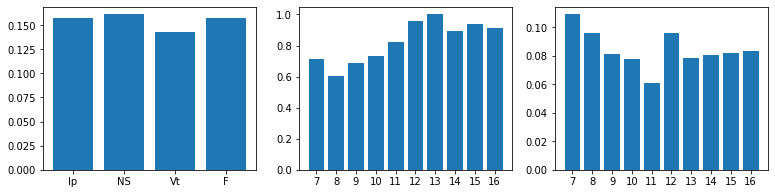

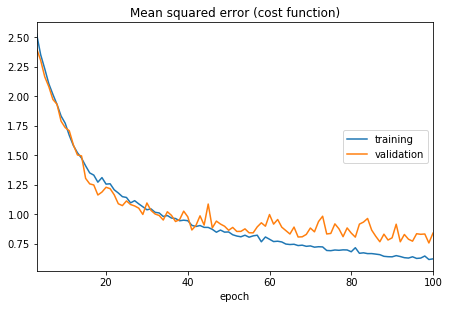

Mean squared error (cost function):
training   (min:    0.617, max:    3.246, cur:    0.622)
validation (min:    0.757, max:    2.981, cur:    0.840)
446/446 [==============================] - 77s 173ms/step - loss: 0.6222 - val_loss: 0.8404


In [11]:
fit = lambda: gen.fit( DDS.skip(3000).batch(100), validation_data=DDS.take(3000).batch(100), epochs=100,
                      callbacks=[PlotLossesCallback(), PlotRelevanceCallback()], shuffle=False )
models.base.fn_thread(gen, fit).control_panel()

NameError: name 'h' is not defined

In [ ]:
gen.layers[1].weights

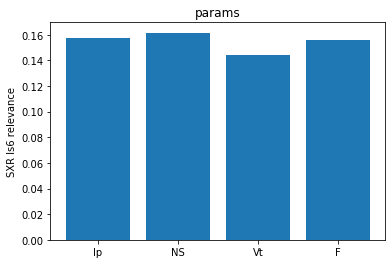

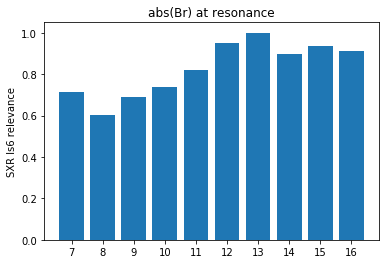

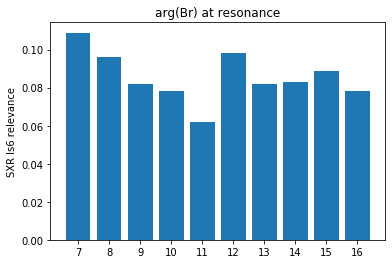

In [568]:
index = qsh[0].n
w = gen.layers[1].weights
%matplotlib inline

def plot_bar_x(index, w, title):
    # this is for plotting purpose
    plt.figure(title)
    plt.bar(index, w)
    # plt.xlabel('n', fontsize=5)
    plt.ylabel('SXR ls6 relevance', fontsize=10)
    plt.xticks(index, fontsize=10)
    plt.title(title)
    plt.show()

p,re,im = w[0][0:4], w[0][4:14], w[0][14:24]
plot_bar_x(['Ip','NS','Vt','F'], p, 'params')
plot_bar_x(index, re, 'abs(Br) at resonance')
plot_bar_x(index, im, 'arg(Br) at resonance')


In [28]:
# vae1.save('step12_vae1_p2SXR_Br_rs_ABSARG')
vae1.load('step12_vae1_p2SXR_Br_rs_ABSARG')
# vae1.load('step12_vae1_p2SXR')
# vae.load('step12_gan_PBr_reim')

In [5]:
pos = 0

In [ ]:
print(pos)
d_pos = [x for x in ds.skip(pos).batch(1).take(1)][0]
qp = qsh[pos]
qp.plot_countour()


W0905 14:59:55.759104 139775700584256 legend.py:1282] No handles with labels found to put in legend.


68


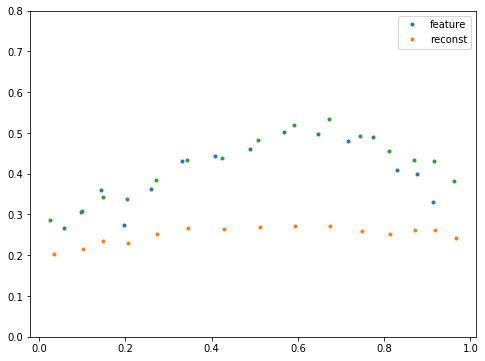

In [78]:
print(pos)
d_pos = [x for x in ds.skip(pos).batch(1).take(1)][0]

def plot(xy, name=None):
    fig = plt.figure('plot')
    fig.set_size_inches(8, 6, forward=True)
    ax = plt.gca()
    ax.legend()
    ax.set_ylim(0.,0.8)
    xy = tf.reshape(xy, [-1])
    x,y = tf.split(xy, num_or_size_splits=2, axis=0)
    plt.plot(x,y,'.', label=name)

xy = d_pos[1]
XY_vae = vae(xy, training=False)
ls = gen(d_pos[0], training=False)
XY = vae.decode(ls, training=False)
# XY = tf.sigmoid(XY)
plot(xy, 'feature')
plot(XY, 'reconst')
plot(XY_vae, 'vae')
pos += 1